VN2 EDA - Order #1

This notebook explores the five Week 0 datasets:
- Initial State
- Sales
- In Stock
- Master
- Submission Template

We’ll inspect schemas, check missingness, compute demand stats, and summarize inventory positions.

Table of contents
1. Setup and file handles
2. Project import helper
3. Artifacts directories
4. Schema and missingness checks
5. Reshaping to long format
6. Demand statistics per item
7. Merged meta table
8. Current state and inventory position
9. Naive base-stock gaps (P=3)
10. Group summaries
11. Stockout exposure
12. Export artifacts and notebook-based submission
13. CLI command for reproducible submission
14. Availability vs demand (exported)
15. ABC/XYZ segmentation
16. Variability diagnostics (exported)
17. Service-level sensitivity sweep (exported)
18. ABC/XYZ heatmap (exported)

Assumptions
- Use `End Inventory` as Week 1 on-hand.
- Lead time = 2 weeks, review period = 1 week → protection period P=3.
- Shortage cost = 1.0, holding cost = 0.2 per unit per week; no holding on in-transit.



Setup and file handles

- Imports core libraries (pandas, numpy, matplotlib, seaborn) and sets a consistent theme.
- Defines paths to the five Order #1 CSV files in `../data/`.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

DATA_DIR = Path("../data").resolve()
files = {
    "initial": DATA_DIR / "Week 0 - 2024-04-08 - Initial State.csv",
    "sales": DATA_DIR / "Week 0 - 2024-04-08 - Sales.csv",
    "in_stock": DATA_DIR / "Week 0 - In Stock.csv",
    "master": DATA_DIR / "Week 0 - Master.csv",
    "template": DATA_DIR / "Week 0 - Submission Template.csv",
}
files


{'initial': PosixPath('/Users/senoni/noni/vn2inventory/data/Week 0 - 2024-04-08 - Initial State.csv'),
 'sales': PosixPath('/Users/senoni/noni/vn2inventory/data/Week 0 - 2024-04-08 - Sales.csv'),
 'in_stock': PosixPath('/Users/senoni/noni/vn2inventory/data/Week 0 - In Stock.csv'),
 'master': PosixPath('/Users/senoni/noni/vn2inventory/data/Week 0 - Master.csv'),
 'template': PosixPath('/Users/senoni/noni/vn2inventory/data/Week 0 - Submission Template.csv')}

Project import helper

- Adds project root to `sys.path` so we can `import vn2inventory` directly from the notebook.


In [2]:
# Ensure project root is on sys.path for `import vn2inventory`
import sys
from pathlib import Path as _P
PROJECT_ROOT = _P("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

try:
    import vn2inventory  # noqa: F401
    print("Imported vn2inventory from:", PROJECT_ROOT)
except Exception as e:
    print("Import error:", e)



Imported vn2inventory from: /Users/senoni/noni/vn2inventory


Artifacts directories

- Defines `ART`, `SUB`, and `FIGS` used by later cells to save datasets and figures.
- These are created if they do not exist.


In [3]:
# Artifact directories (available early for savefig)
from pathlib import Path as _Path
ART = _Path("../artifacts/order1").resolve()
SUB = _Path("../submissions").resolve()
FIGS = ART / "figs"
for p in [ART, SUB, FIGS]:
    p.mkdir(parents=True, exist_ok=True)
ART, SUB, FIGS


(PosixPath('/Users/senoni/noni/vn2inventory/artifacts/order1'),
 PosixPath('/Users/senoni/noni/vn2inventory/submissions'),
 PosixPath('/Users/senoni/noni/vn2inventory/artifacts/order1/figs'))

Schema and missingness checks

- Prints shapes, dtypes, and total null counts for each input file.
- Use to confirm assumptions and catch unexpected type parsing issues early.


In [4]:
# Load CSVs
init_df = pd.read_csv(files["initial"])  # Initial state
sales_wide = pd.read_csv(files["sales"])   # Sales history (wide by week)
avail_wide = pd.read_csv(files["in_stock"])# In-stock boolean (wide by week)
master_df = pd.read_csv(files["master"])  # Product hierarchy
template_df = pd.read_csv(files["template"]) # Submission index order

init_df.head(), sales_wide.head(2), avail_wide.head(2), master_df.head(2), template_df.head(2)


(   Store  Product  Start Inventory  Sales  Missed Sales  End Inventory  \
 0      0      126                0      0             0              3   
 1      0      182                0      0             0              1   
 2      1      124                0      0             0              6   
 3      2      124                0      0             0              9   
 4      2      126                0      0             0              3   
 
    In Transit W+1  In Transit W+2  Holding Cost  Shortage Cost  \
 0               0               3             0              0   
 1               0               1             0              0   
 2               0               6             0              0   
 3               0               7             0              0   
 4               0               1             0              0   
 
    Cumulative Holding Cost  Cumulative Shortage Cost  
 0                        0                         0  
 1                        0     

Reshaping to long format

- `Sales.csv` and `In Stock.csv` are provided in wide weekly columns.
- Melt to long format with columns: `Store`, `Product`, `Week`, `SalesQty` / `InStock`.
- Coerce types: numeric sales; boolean availability.


In [5]:
# Basic schema and missingness
summary = {}
for name, df in {
    "initial": init_df,
    "sales": sales_wide,
    "in_stock": avail_wide,
    "master": master_df,
    "template": template_df,
}.items():
    summary[name] = {
        "shape": df.shape,
        "dtypes": df.dtypes.astype(str).to_dict(),
        "null_counts": df.isna().sum().sum(),
    }
summary


{'initial': {'shape': (599, 12),
  'dtypes': {'Store': 'int64',
   'Product': 'int64',
   'Start Inventory': 'int64',
   'Sales': 'int64',
   'Missed Sales': 'int64',
   'End Inventory': 'int64',
   'In Transit W+1': 'int64',
   'In Transit W+2': 'int64',
   'Holding Cost': 'int64',
   'Shortage Cost': 'int64',
   'Cumulative Holding Cost': 'int64',
   'Cumulative Shortage Cost': 'int64'},
  'null_counts': np.int64(0)},
 'sales': {'shape': (599, 159),
  'dtypes': {'Store': 'int64',
   'Product': 'int64',
   '2021-04-12': 'float64',
   '2021-04-19': 'float64',
   '2021-04-26': 'float64',
   '2021-05-03': 'float64',
   '2021-05-10': 'float64',
   '2021-05-17': 'float64',
   '2021-05-24': 'float64',
   '2021-05-31': 'float64',
   '2021-06-07': 'float64',
   '2021-06-14': 'float64',
   '2021-06-21': 'float64',
   '2021-06-28': 'float64',
   '2021-07-05': 'float64',
   '2021-07-12': 'float64',
   '2021-07-19': 'float64',
   '2021-07-26': 'float64',
   '2021-08-02': 'float64',
   '2021-08-09

Demand statistics per item

- Aggregates sales by `(Store, Product)` across all weeks: mean, std (sample), and observation count.
- Fallback: if `std` is NaN (few observations), use `sqrt(mean)` as a rough variance proxy.


In [6]:
# Melt sales and availability to long format for aggregation
id_cols = ["Store", "Product"]

sales_long = sales_wide.melt(
    id_vars=id_cols,
    var_name="Week",
    value_name="SalesQty",
)

avail_long = avail_wide.melt(
    id_vars=id_cols,
    var_name="Week",
    value_name="InStock",
)

# Coerce numeric SalesQty and boolean InStock
sales_long["SalesQty"] = pd.to_numeric(sales_long["SalesQty"], errors="coerce").fillna(0.0)
avail_long["InStock"] = avail_long["InStock"].astype(str).str.lower().map({"true": True, "false": False})

sales_long.head(), avail_long.head()


(   Store  Product        Week  SalesQty
 0      0      126  2021-04-12       0.0
 1      0      182  2021-04-12       0.0
 2      1      124  2021-04-12      13.0
 3      2      124  2021-04-12       5.0
 4      2      126  2021-04-12       0.0,
    Store  Product        Week  InStock
 0      0      126  2021-04-12     True
 1      0      182  2021-04-12    False
 2      1      124  2021-04-12     True
 3      2      124  2021-04-12     True
 4      2      126  2021-04-12    False)

Merged meta table

- Merges demand stats with availability rates and product hierarchy for downstream analysis.
- `meta.describe()` gives an overview of distributions and potential missing fields.


In [7]:
# Demand stats by (Store, Product)
demand_stats = (
    sales_long.groupby(id_cols)["SalesQty"].agg(["mean", "std", "count"])\
        .rename(columns={"mean": "mean_demand", "std": "std_demand", "count": "observations"})
)
# handle std NaNs
demand_stats["std_demand"] = demand_stats["std_demand"].fillna(demand_stats["mean_demand"].clip(lower=0.0).pow(0.5))
demand_stats.sort_values("mean_demand", ascending=False).head(10)


mean_demand  std_demand  observations
Store Product                                       
61    124        98.840764   64.181385           157
      23         87.891720   68.802074           157
60    125        84.356688   37.852448           157
      23         52.968153   48.961578           157
64    17         50.006369   20.293518           157
62    23         48.414013   37.175096           157
63    23         45.898089   42.398625           157
      124        44.783439   48.670967           157
64    23         33.114650   30.651258           157
61    48         32.611465   15.562797           157

Current state and inventory position

- Uses `End Inventory` as Week 1 on-hand per competition clarification.
- Computes `OnOrder = InTransit_W1 + InTransit_W2` and `InvPosition = OnHand + OnOrder`.
- Summary totals printed for quick sense-check.


In [8]:
# Availability rate by (Store, Product)
availability = (
    avail_long.groupby(id_cols)["InStock"].mean().rename("availability_rate")
)

# Merge with demand stats and hierarchy
meta = (demand_stats.join(availability, how="left")
                    .reset_index()
                    .merge(master_df, on=id_cols, how="left"))

meta.describe(include="all")


,Store,Product,mean_demand,std_demand,observations,availability_rate,ProductGroup,Division,Department,DepartmentGroup,StoreFormat,Format
count,599.000000,599.000000,599.000000,599.000000,599.0,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,56.881469,137.766277,2.941718,2.766223,157.0,0.893590,309149.320534,3091.442404,30.864775,9.001669,1.876461,189.398998
std,12.868033,83.772379,8.231992,5.808472,0.0,0.136627,144830.725627,1448.320031,14.479373,2.702346,0.410681,74.010322
min,0.000000,0.000000,0.318471,0.592842,157.0,0.442424,20318.000000,203.000000,2.000000,1.000000,1.000000,13.000000
25%,60.000000,68.500000,0.783439,1.096790,157.0,0.845455,200606.000000,2006.000000,20.000000,9.000000,2.000000,216.000000
50%,61.000000,126.000000,1.076433,1.448162,157.0,0.957576,301202.000000,3012.000000,30.000000,9.000000,2.000000,216.000000
75%,62.000000,208.500000,2.009554,2.473163,157.0,0.993939,401001.000000,4010.000000,40.000000,11.000000,2.000000,216.000000
max,66.000000,296.000000,98.840764,68.802074,157.0,1.000000,590001.000000,5900.000000,59.000000,12.000000,5.000000,521.000000


Naive base-stock gaps (P=3)

- Computes base stock using `S = mean*P + 1.64*std*sqrt(P)` and compares with current inventory position.
- High `gap` items are initial candidates for orders; final policy may differ based on costs.


In [9]:
# Current inventory state summary
state_cols = [
    "Store","Product","Start Inventory","Sales","Missed Sales","End Inventory",
    "In Transit W+1","In Transit W+2"
]
state = init_df[state_cols].copy()
state.rename(columns={
    # Per competition clarifications: use End Inventory as starting on-hand for Week 1
    "End Inventory":"OnHand",
    "In Transit W+1":"InTransit_W1",
    "In Transit W+2":"InTransit_W2",
}, inplace=True)
state["OnOrder"] = state[["InTransit_W1","InTransit_W2"]].sum(axis=1)
state["InvPosition"] = state["OnHand"] + state["OnOrder"]

state_summary = {
    "on_hand_total": float(state["OnHand"].sum()),
    "on_order_total": float(state["OnOrder"].sum()),
    "inventory_position_total": float(state["InvPosition"].sum()),
    "skus": int(state.shape[0]),
}
state_summary


{'on_hand_total': 2225.0,
 'on_order_total': 1699.0,
 'inventory_position_total': 3924.0,
 'skus': 599}

Group summaries

- Department and ProductGroup summaries based on total mean demand.
- Use to spot high-volume groups for targeted policy tuning and exceptions.


In [10]:
# Join demand and state to estimate naive base-stock and implied initial gaps
P = 2 + 1  # lead time + review period
joined = (demand_stats.reset_index()
          .merge(state[["Store","Product","OnHand","OnOrder","InvPosition"]], on=["Store","Product"], how="left")
          .merge(master_df, on=["Store","Product"], how="left"))

joined["base_stock"] = (joined["mean_demand"].clip(lower=0.0) * P + 1.64 * joined["std_demand"].clip(lower=0.0) * np.sqrt(P))
joined["gap"] = (joined["base_stock"] - joined["InvPosition"]).clip(lower=0.0)

joined.sort_values("gap", ascending=False).head(15)[["Store","Product","mean_demand","std_demand","OnHand","OnOrder","InvPosition","base_stock","gap"]]


,Store,Product,mean_demand,std_demand,OnHand,OnOrder,InvPosition,base_stock,gap
277,61,124,98.840764,64.181385,100,99,199,478.833580,279.833580
201,61,23,87.891720,68.802074,96,96,192,459.111807,267.111807
133,60,125,84.356688,37.852448,80,79,159,360.592341,201.592341
94,60,23,52.968153,48.961578,59,59,118,297.982922,179.982922
532,63,23,45.898089,42.398625,63,62,125,258.130246,133.130246
418,62,23,48.414013,37.175096,60,60,120,250.840252,130.840252
589,64,23,33.114650,30.651258,38,37,75,186.410787,111.410787
586,64,17,50.006369,20.293518,49,49,98,207.664132,109.664132
554,63,124,44.783439,48.670967,83,83,166,272.603283,106.603283
134,60,126,20.305732,18.916708,16,14,30,114.651303,84.651303


Stockout exposure

- Computes fraction of weeks with `InStock=False` by `(Store, Product)`; higher values suggest chronic under-supply or listing gaps.
- Table lists most exposed items (sorted by stockout rate, then mean demand).


In [11]:
# Grouped views: by Department and ProductGroup
agg_dept = (joined.groupby("Department")["mean_demand"].sum().sort_values(ascending=False).head(10))
agg_pg = (joined.groupby("ProductGroup")["mean_demand"].sum().sort_values(ascending=False).head(10))
agg_dept, agg_pg


(Department
 24    563.993631
 14    278.783439
 30    238.636943
 40    193.490446
 53    149.955414
 20     80.222930
 3      53.802548
 47     34.777070
 26     26.407643
 54     24.955414
 Name: mean_demand, dtype: float64,
 ProductGroup
 240201    563.993631
 140402    268.286624
 301202    202.732484
 530401    149.955414
 401001     66.044586
 30103      53.089172
 400702     39.910828
 401003     27.070064
 200303     16.847134
 301241     16.503185
 Name: mean_demand, dtype: float64)

Export artifacts and notebook-based submission

- Saves `sales_long.csv` for the CLI and writes `orders_round1_notebook.csv` using the library `compute_orders`.
- Policy params: lead=2, review=1, shortage=1.0, holding=0.2.
- Index order preserved from Submission Template.


In [12]:
# Stockout exposure: fraction of weeks with InStock=False
stockout = (avail_long.assign(Out=~avail_long["InStock"]).groupby(id_cols)["Out"].mean().rename("stockout_rate"))
joined2 = demand_stats.join(stockout, how="left").reset_index()
joined2.sort_values(["stockout_rate","mean_demand"], ascending=[False, False]).head(15)


,Store,Product,mean_demand,std_demand,observations,stockout_rate
82,59,126,1.426752,2.722659,157,0.557576
352,61,232,0.369427,0.778613,157,0.557576
161,60,229,0.592357,1.285797,157,0.551515
351,61,231,0.414013,1.086305,157,0.551515
350,61,230,0.318471,0.640895,157,0.545455
162,60,235,1.095541,1.767888,157,0.515152
576,63,237,1.114650,2.270118,157,0.509091
507,62,226,1.299363,2.001490,157,0.503030
358,61,242,0.585987,1.560919,157,0.503030
81,58,17,3.687898,4.802314,157,0.496970


CLI command for reproducible submission

- Generates a command tailored to Order #1 column names (`End Inventory` for on-hand, in-transit columns included).
- Writes `orders_round1_cli.csv` when run in a terminal.
- Ensure `artifacts/order1/sales_long.csv` was created earlier in the notebook.


In [13]:
# Export artifacts for CLI usage and write a submission from notebook
from pathlib import Path
from vn2inventory.policy import compute_orders

ART = Path("../artifacts/order1").resolve()
SUB = Path("../submissions").resolve()
ART.mkdir(parents=True, exist_ok=True)
SUB.mkdir(parents=True, exist_ok=True)

# 1) Save long-format sales for CLI
sales_long_out = ART / "sales_long.csv"
sales_long.to_csv(sales_long_out, index=False)

# 2) Prepare inputs and compute orders via library
index_df = template_df[["Store","Product"]].set_index(["Store","Product"])  # preserves submission order
current_state = (state[["Store","Product","OnHand","OnOrder"]]
                 .rename(columns={"OnHand":"on_hand","OnOrder":"on_order"})
                 .set_index(["Store","Product"]))

orders = compute_orders(
    index_df=index_df,
    demand_stats=demand_stats,  # already indexed
    current_state=current_state,
    lead_time_weeks=2,
    review_period_weeks=1,
    shortage_cost_per_unit=1.0,
    holding_cost_per_unit_per_week=0.2,
)

submission_nb = index_df.copy()
submission_nb["order_qty"] = orders.values
out_nb = SUB / "orders_round1_notebook.csv"
submission_nb.to_csv(out_nb, index=True)

out_nb, sales_long_out


(PosixPath('/Users/senoni/noni/vn2inventory/submissions/orders_round1_notebook.csv'),
 PosixPath('/Users/senoni/noni/vn2inventory/artifacts/order1/sales_long.csv'))

Availability vs demand

- Goal: Is lower availability correlated with high demand? Plot availability rate vs mean demand per `(Store, Product)`.
- Metric: Pearson correlation printed below.
- Output: Saves `availability_vs_mean_demand.png`.


In [14]:
# Print a ready-to-run CLI command wired for Order #1 column names
from textwrap import dedent
cmd = dedent(f"""
python -m vn2inventory order \
  --sales "{(ART / 'sales_long.csv').resolve()}" \
  --current "{files['initial']}" \
  --index "{files['template']}" \
  --out "{(SUB / 'orders_round1_cli.csv').resolve()}" \
  --store-col Store --product-col Product \
  --sales-qty-col SalesQty --sales-date-col Week \
  --on-hand-col "End Inventory" \
  --in-transit-cols "In Transit W+1,In Transit W+2"
""")
print(cmd)



python -m vn2inventory order   --sales "/Users/senoni/noni/vn2inventory/artifacts/order1/sales_long.csv"   --current "/Users/senoni/noni/vn2inventory/data/Week 0 - 2024-04-08 - Initial State.csv"   --index "/Users/senoni/noni/vn2inventory/data/Week 0 - Submission Template.csv"   --out "/Users/senoni/noni/vn2inventory/submissions/orders_round1_cli.csv"   --store-col Store --product-col Product   --sales-qty-col SalesQty --sales-date-col Week   --on-hand-col "End Inventory"   --in-transit-cols "In Transit W+1,In Transit W+2"



ABC/XYZ segmentation

- ABC: rank by mean demand; cumulative shares split at 80% (A), 95% (B), remainder (C).
- XYZ: CV buckets — X (≤0.5), Y (0.5–1), Z (>1).
- Pivot tables below show counts and shares of items per bucket.


{'pearson_corr': 0.1217535088967942}


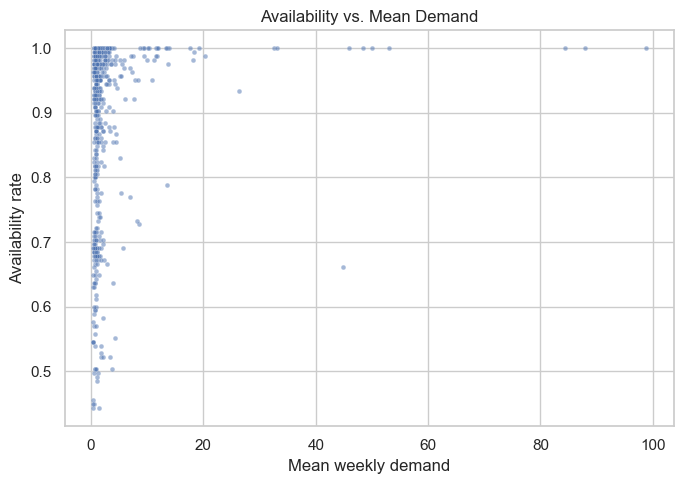

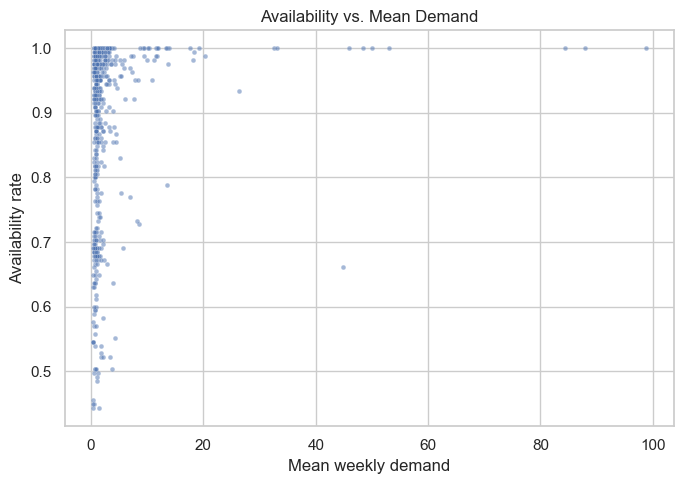

In [15]:
# Availability vs. mean demand scatter and correlation
md = demand_stats.reset_index()
md = md.merge(availability.reset_index(), on=["Store","Product"], how="left")

fig, ax = plt.subplots(figsize=(7,5))
import seaborn as sns
sns.scatterplot(data=md, x="mean_demand", y="availability_rate", s=12, alpha=0.5, ax=ax)
ax.set_xlabel("Mean weekly demand")
ax.set_ylabel("Availability rate")
ax.set_title("Availability vs. Mean Demand")

corr = md[["mean_demand","availability_rate"]].corr().iloc[0,1]
print({"pearson_corr": float(corr)})
fig.tight_layout()
fig.savefig(FIGS / "availability_vs_mean_demand.png", dpi=150)
fig


Variability diagnostics

- CV histogram: distribution of coefficient of variation (std/mean) across SKUs.
- Mean vs Std (log-log): sanity check for variance scaling and to spot outliers.
- Output: Saves `cv_hist_and_mean_vs_std.png`.


In [16]:
# ABC/XYZ segmentation
# ABC by cumulative share of total mean demand
meta2 = meta.copy()
meta2 = meta2.sort_values("mean_demand", ascending=False)
meta2["cum_share"] = meta2["mean_demand"].cumsum() / meta2["mean_demand"].sum()

conditions = [meta2["cum_share"] <= 0.8, meta2["cum_share"] <= 0.95]
choices = ["A", "B"]
meta2["ABC"] = np.select(conditions, choices, default="C")

# XYZ by coefficient of variation CV = std / mean
cv = (meta2["std_demand"] / meta2["mean_demand"].replace(0, np.nan)).fillna(np.inf)
meta2["CV"] = cv
meta2["XYZ"] = pd.cut(cv, bins=[-np.inf, 0.5, 1.0, np.inf], labels=["X","Y","Z"])

# Heatmap-like pivot counts
pivot_counts = meta2.pivot_table(index="ABC", columns="XYZ", values="mean_demand", aggfunc="count", fill_value=0)
pivot_shares = pivot_counts / pivot_counts.values.sum()

pivot_counts, pivot_shares.round(3)


/var/folders/r5/nxjbf29562z82zbz61mnfz200000gn/T/ipykernel_14398/3249538294.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_counts = meta2.pivot_table(index="ABC", columns="XYZ", values="mean_demand", aggfunc="count", fill_value=0)


(XYZ   X   Y    Z
 ABC             
 A    15  77  110
 B     0   8  246
 C     0   0  143,
 XYZ      X      Y      Z
 ABC                     
 A    0.025  0.129  0.184
 B    0.000  0.013  0.411
 C    0.000  0.000  0.239)

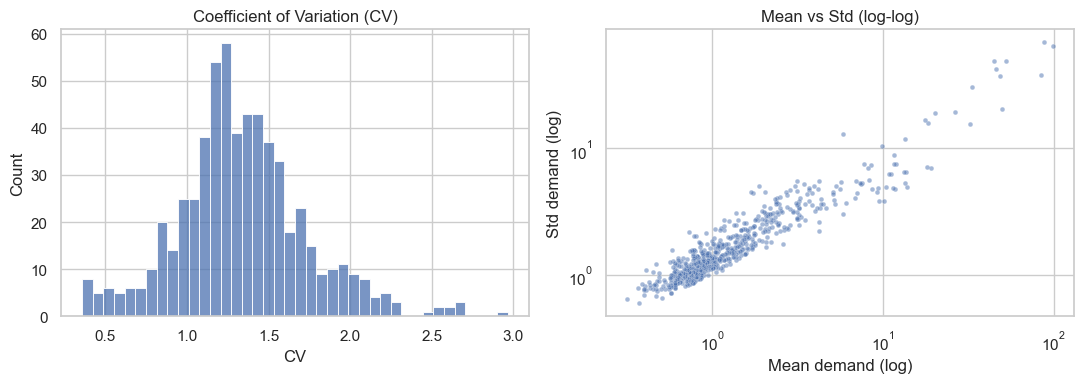

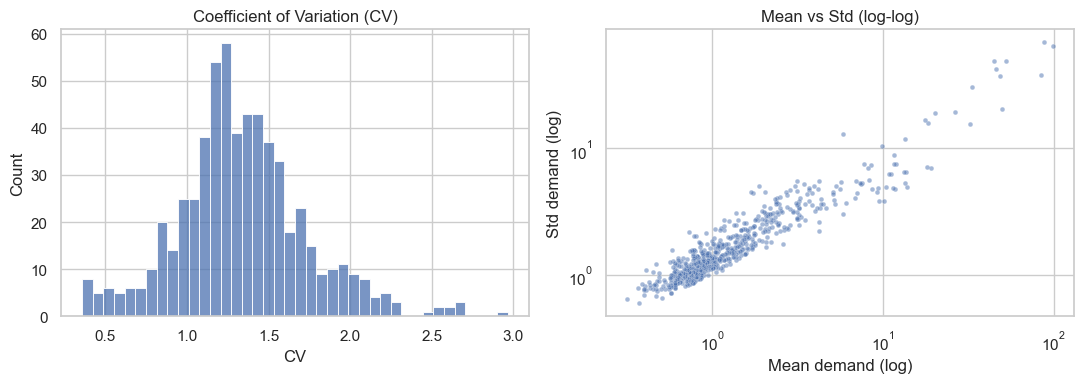

In [17]:
# Visualize CV histogram and mean vs std (log-log)
fig, axs = plt.subplots(1,2, figsize=(11,4))
import seaborn as sns
sns.histplot(meta2["CV"].replace(np.inf, np.nan).dropna(), bins=40, ax=axs[0])
axs[0].set_title("Coefficient of Variation (CV)")
axs[0].set_xlabel("CV")
axs[0].set_ylabel("Count")

sns.scatterplot(x=meta2["mean_demand"], y=meta2["std_demand"], s=12, alpha=0.5, ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("Mean demand (log)")
axs[1].set_ylabel("Std demand (log)")
axs[1].set_title("Mean vs Std (log-log)")
fig.tight_layout()
fig.savefig(FIGS / "cv_hist_and_mean_vs_std.png", dpi=150)
fig


Service-level sensitivity sweep

- Purpose: Show how total order volume reacts to different target service levels for P=3 weeks.
- Method: Base-stock S = mean*P + z*std*sqrt(P), where z is the standard-normal quantile for the chosen service level.
- Use: Pick a policy that balances shortage vs holding costs; cross-check against cost assumptions (1.0 shortage, 0.2 weekly holding).
- Output: Saves `service_level_sensitivity.png`.


,service_level,z,total_order_units,median_order,p90_order
0,0.800,0.841621,3777.680272,2.958320,9.623860
1,0.850,1.036433,4336.781865,3.457420,10.974127
2,0.900,1.281552,5040.259320,4.091404,12.539143
3,0.950,1.644854,6082.918890,5.060175,15.060781
4,0.975,1.959964,6987.270581,5.862566,17.161615
5,0.990,2.326348,8038.774848,6.760820,19.803659


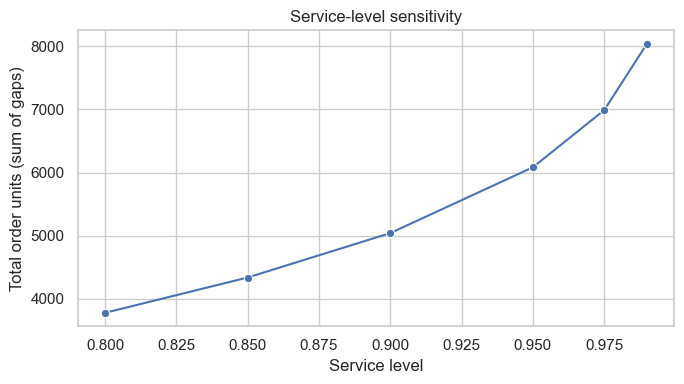

In [18]:
# Service-level sensitivity sweep
# We vary service level (or critical ratio) and compute total order units and implied base-stock gap
levels = [0.80, 0.85, 0.90, 0.95, 0.975, 0.99]
P = 3
from vn2inventory.policy import _inv_normal_cdf

rows = []
for sl in levels:
    z = _inv_normal_cdf(sl)
    base_stock = (demand_stats["mean_demand"] * P + z * demand_stats["std_demand"] * np.sqrt(P)).clip(lower=0.0)
    gap = (base_stock - state.set_index(["Store","Product"])["InvPosition"]).clip(lower=0.0)
    rows.append({
        "service_level": sl,
        "z": float(z),
        "total_order_units": float(gap.sum()),
        "median_order": float(gap.median()),
        "p90_order": float(gap.quantile(0.9)),
    })

sweep = pd.DataFrame(rows)
fig, ax = plt.subplots(figsize=(7,4))
import seaborn as sns
sns.lineplot(data=sweep, x="service_level", y="total_order_units", marker="o", ax=ax)
ax.set_xlabel("Service level")
ax.set_ylabel("Total order units (sum of gaps)")
ax.set_title("Service-level sensitivity")
fig.tight_layout()
fig.savefig(FIGS / "service_level_sensitivity.png", dpi=150)
sweep


ABC/XYZ heatmap (exported)

- Purpose: Visualize the cross-tab of ABC (by cumulative mean-demand share) vs XYZ (by CV buckets) to quickly spot portfolio structure.
- Output: Saves `abc_xyz_counts_heatmap.png` under `artifacts/order1/figs/`.
- Interpretation:
  - A: ~80% of demand; B: next ~15%; C: tail.
  - X: stable (CV≤0.5), Y: medium (0.5–1), Z: erratic (>1).


In [19]:
# Create figs dir
from pathlib import Path as _Path
FIGS = _Path("../artifacts/order1/figs").resolve()
FIGS.mkdir(parents=True, exist_ok=True)
FIGS


PosixPath('/Users/senoni/noni/vn2inventory/artifacts/order1/figs')

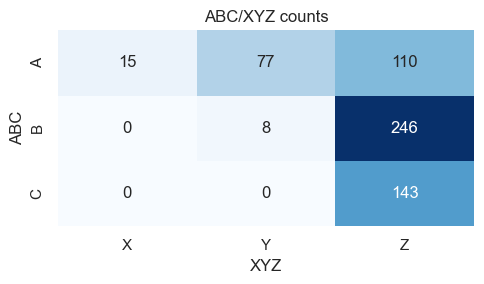

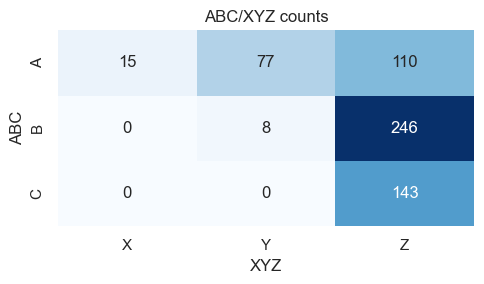

In [20]:
# ABC/XYZ heatmap figure and export
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(pivot_counts, annot=True, fmt=".0f", cmap="Blues", cbar=False, ax=ax)
ax.set_title("ABC/XYZ counts")
fig.tight_layout()
fig.savefig(FIGS / "abc_xyz_counts_heatmap.png", dpi=150)
fig
